In [13]:
import pyro
import torch
from pyro.optim import SGD, Adam
import pyro.distributions as dist
from torch.distributions import constraints
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, norm
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Introduction

In this notebook we the simple generative model from Slide 18, which you also experimented with in the notebook *student_BBVI.ipynb*:
 * https://www.moodle.aau.dk/mod/resource/view.php?id=1049031

In the previous notebook we derived the required gradients manually. Here we instead rely on differentiation functionality in Pyro, which, in turn is based n PyTorch.

## The model in plate notation

<img src="https://www.moodle.aau.dk/pluginfile.php/1695750/mod_folder/content/0/mean_model.png?forcedownload=1" width="600">

## The model defined in Pyro

Here we define the probabilistic model. Notice the close resemblance with the plate specification above.

In [3]:
def mean_model(data):

    # Define the random variable mu having a noral distribution as prior
    mu = pyro.sample("mu", dist.Normal(0.0,1000.0))

    # and now the plate holding the observations. The number of observations are determined by the data set 
    # supplied to the function. 
    with pyro.plate("x_plate"):
        pyro.sample(f"obs", dist.Normal(mu, 1), obs=data)

## The variational distribution

In Pyro the variational distribution is defined as a so-called guide. In this example our variational distribution is a beta distribution with parameters q_alpha and q_beta:

$$
q(\mu)= \mathit{Normal}(\mu | q_{mu}, 1)
$$

In [4]:
def mean_guide(data):

    # We initialize the variational parameter to 0.0. 
    q_mu = pyro.param("q_mu", torch.tensor(0.0))

    q_sigma = pyro.param("q_sigma", torch.tensor(1.0), constraint=constraints.positive)
    # The name of the random variable of the variational distribution must match the name of the corresponding
    # variable in the model exactly.
    pyro.sample("mu", dist.Normal(q_mu, q_sigma))

## Learning

Here we encapsulate the learning steps, relying on standard stochastic gradient descent

In [5]:
def learn(data):

    pyro.clear_param_store()

    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model=mean_model,
                         guide=mean_guide,
                         optim=SGD({'lr':0.0001}),
                         loss=elbo)

    num_steps = 1000
    for step in range(num_steps):
        loss = svi.step(data)

        if step % 50 == 0:
            print(f"Loss for iteration {step}: {loss}")

## Generate data and learn model

In [17]:
data_mean = 10.0
data = torch.tensor(np.random.normal(loc=data_mean, scale=1.0, size=1000),dtype=torch.float)
learn(data)

Loss for iteration 0: 56535.37224268913
Loss for iteration 50: 1449.1994786262512
Loss for iteration 100: 1419.46657538414
Loss for iteration 150: 1421.3461380004883
Loss for iteration 200: 1439.2931314706802
Loss for iteration 250: 1446.56522667408
Loss for iteration 300: 1438.563308954239
Loss for iteration 350: 1419.12491440773
Loss for iteration 400: 1472.2236576080322
Loss for iteration 450: 1426.7166031599045
Loss for iteration 500: 1416.5584343671799
Loss for iteration 550: 1416.5937269926071
Loss for iteration 600: 1418.7953009605408
Loss for iteration 650: 1424.6695479154587
Loss for iteration 700: 1416.7727209329605
Loss for iteration 750: 1430.3280556201935
Loss for iteration 800: 1420.4648576974869
Loss for iteration 850: 1422.6401110887527
Loss for iteration 900: 1419.537272810936
Loss for iteration 950: 1417.164669394493


Get the learned variational parameter

## The learned parameters

In [23]:
qmu = pyro.param("q_mu").item()
qsigma = pyro.param("q_sigma").item()

In [24]:
print(f"Mean of vaiational distribution: {qmu}")
print(f"Variance of variational distribution: {qsigma}")

Mean of vaiational distribution: 9.976456642150879
Variance of variational distribution: 0.07330299913883209


## Plot the results

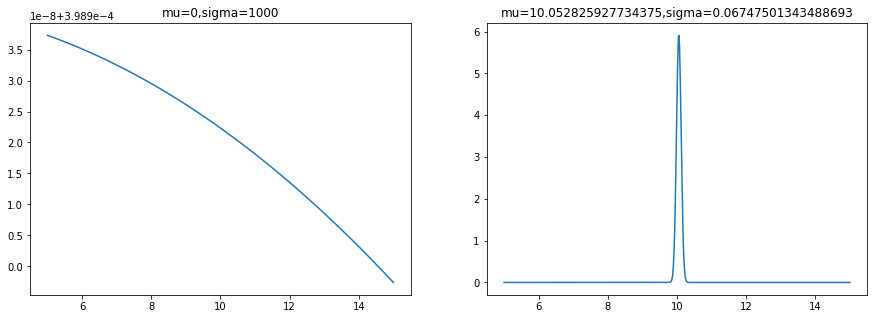

In [22]:
x = np.linspace(data_mean-5,data_mean+5,1000)
plt.figure(figsize=(15, 5))

# Prior distribution
plt.subplot(1, 2, 1)
y = norm.pdf(x, 0, 1000)
plt.title(f'mu={0},sigma={1000}')
plt.plot(x,y)

# Posterior distribution
plt.subplot(1, 2, 2)
y = norm.pdf(x, qmu,qsigma)
plt.title(f'mu={qmu},sigma={qsigma}')
plt.plot(x,y)

## Exercise
* Adapt the code above to accomodate a slight more rich variational distribution, where we also have a variational parameter for the standard deviation:
$$
q(\mu)= \mathit{Normal}(\mu | q_{mu}, q_{std})
$$
* Experiment with different data sets and parameter values. Try visualizing the variational posterior distribution.